# Etapa 1. Construcción de un modelo base con datos de un solo sujeto.

## Ingesta y preprocesamiento de datos 

In [ ]:
# Paso 0: Imports y configuración inicial
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from collections import Counter

plt.style.use('classic')
sns.set_context("notebook")

# Paso 1: Cargar archivo .pkl (S2)
subject_id = "S2"
subject_path = f"C:/Users/nat27/Desktop/Desktop/Proyectos/CienciaDatos/wesad-stress-classifier/data/WESAD/{subject_id}/{subject_id}.pkl"

with open(subject_path, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

In [2]:
# Paso 2: Extraer señales y etiquetas
labels = data['label']
temp_signal = data['signal']['wrist']['TEMP'].flatten()
eda_signal = data['signal']['wrist']['EDA'].flatten()
bvp_signal = data['signal']['wrist']['BVP'].flatten()

# Ajustar etiquetas a frecuencia de 4Hz (TEMP y EDA)
resampled_labels = labels[::int(700/4)]

# Ajustar BVP a frecuencia 4Hz para que coincida con TEMP y EDA
bvp_downsampled = bvp_signal[::int(64/4)]  # BVP original: 64Hz → 4Hz

# Confirmar tamaños iguales
min_len = min(len(temp_signal), len(eda_signal), len(bvp_downsampled), len(resampled_labels))
temp_signal = temp_signal[:min_len]
eda_signal = eda_signal[:min_len]
bvp_downsampled = bvp_downsampled[:min_len]
resampled_labels = resampled_labels[:min_len]

print(len(temp_signal), len(eda_signal), len(bvp_downsampled), len(resampled_labels))

# Paso 3: Definir ventanas
fs = 4
window_sec = 60
step_sec = 30
window_size = fs * window_sec
step_size = fs * step_sec

# Paso 4: Extraer features TEMP, EDA, BVP
features = []
y_labels = []

for start in range(0, len(temp_signal) - window_size, step_size):
    end = start + window_size

    temp_win = temp_signal[start:end]
    eda_win = eda_signal[start:end]
    bvp_win = bvp_downsampled[start:end]
    label_win = resampled_labels[start:end]

    window_mode = int(mode(label_win, keepdims=True).mode[0])

    if window_mode in [1, 2, 3]:
        # TEMP features
        temp_mean = np.mean(temp_win)
        temp_std = np.std(temp_win)
        temp_max = np.max(temp_win)
        temp_min = np.min(temp_win)
        temp_range = temp_max - temp_min
        temp_deriv = np.mean(np.diff(temp_win))

        # EDA features
        eda_mean = np.mean(eda_win)
        eda_std = np.std(eda_win)
        eda_max = np.max(eda_win)
        eda_min = np.min(eda_win)
        eda_range = eda_max - eda_min
        eda_deriv = np.mean(np.diff(eda_win))

        # BVP features
        bvp_mean = np.mean(bvp_win)
        bvp_std = np.std(bvp_win)
        bvp_max = np.max(bvp_win)
        bvp_min = np.min(bvp_win)
        bvp_range = bvp_max - bvp_min
        bvp_deriv = np.mean(np.diff(bvp_win))

        features.append([
            temp_mean, temp_std, temp_max, temp_min, temp_range, temp_deriv,
            eda_mean, eda_std, eda_max, eda_min, eda_range, eda_deriv,
            bvp_mean, bvp_std, bvp_max, bvp_min, bvp_range, bvp_deriv
        ])
        y_labels.append(window_mode)

# Paso 5: Convertir a arrays finales
X_all = np.array(features)
y_all = np.array(y_labels)

print("\nFeatures extraídos:", X_all.shape)
print("Etiquetas válidas:", np.unique(y_all, return_counts=True))

# Vista previa
columns = [
    "temp_mean", "temp_std", "temp_max", "temp_min", "temp_range", "temp_deriv",
    "eda_mean", "eda_std", "eda_max", "eda_min", "eda_range", "eda_deriv",
    "bvp_mean", "bvp_std", "bvp_max", "bvp_min", "bvp_range", "bvp_deriv"
]

df_all = pd.DataFrame(X_all, columns=columns)
df_all['label'] = y_all

df_all.head()

24316 24316 24316 24316

Features extraídos: (71, 18)
Etiquetas válidas: (array([1, 2, 3]), array([38, 21, 12], dtype=int64))


,temp_mean,temp_std,temp_max,temp_min,temp_range,temp_deriv,eda_mean,eda_std,eda_max,eda_min,eda_range,eda_deriv,bvp_mean,bvp_std,bvp_max,bvp_min,bvp_range,bvp_deriv,label
0,35.810000,0.022730,35.87,35.75,0.12,-0.000335,1.319762,0.164836,1.693073,0.874303,0.818770,-0.000708,0.324167,121.952924,485.94,-436.58,922.52,-0.790460,1
1,35.759000,0.051501,35.87,35.66,0.21,-0.000418,1.112433,0.140843,1.436807,0.831920,0.604887,-0.001695,1.550542,100.104825,416.61,-345.19,761.80,-0.304351,1
2,35.710000,0.026331,35.77,35.66,0.11,0.000000,0.888839,0.152056,1.198480,0.679441,0.519039,-0.002118,0.174833,48.319335,201.60,-345.19,546.79,1.461464,1
3,35.727667,0.032576,35.79,35.66,0.13,0.000335,0.701357,0.076838,0.843452,0.570528,0.272924,-0.001126,-0.346917,36.466506,173.22,-187.83,361.05,-0.054226,1
4,35.784667,0.039894,35.87,35.71,0.16,0.000460,0.581121,0.068987,0.720444,0.474428,0.246016,-0.000600,-1.226875,64.844808,234.84,-369.31,604.15,0.186485,1


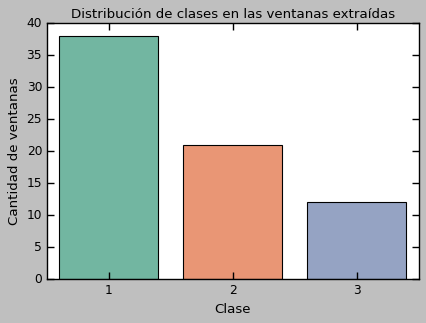

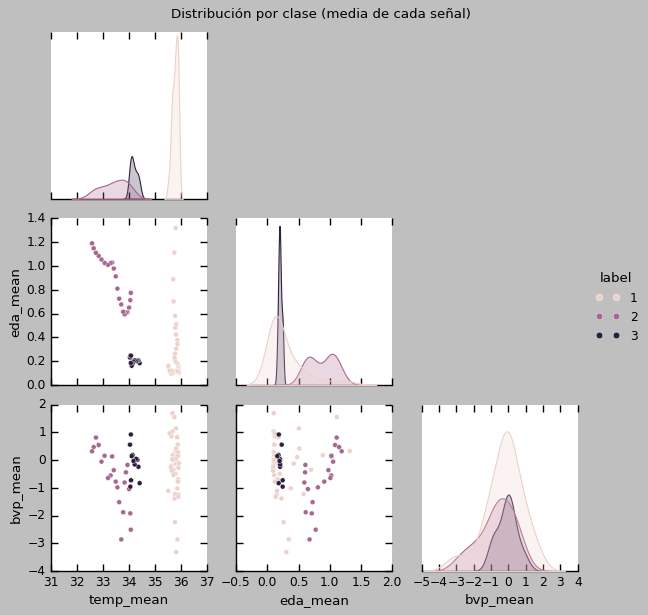

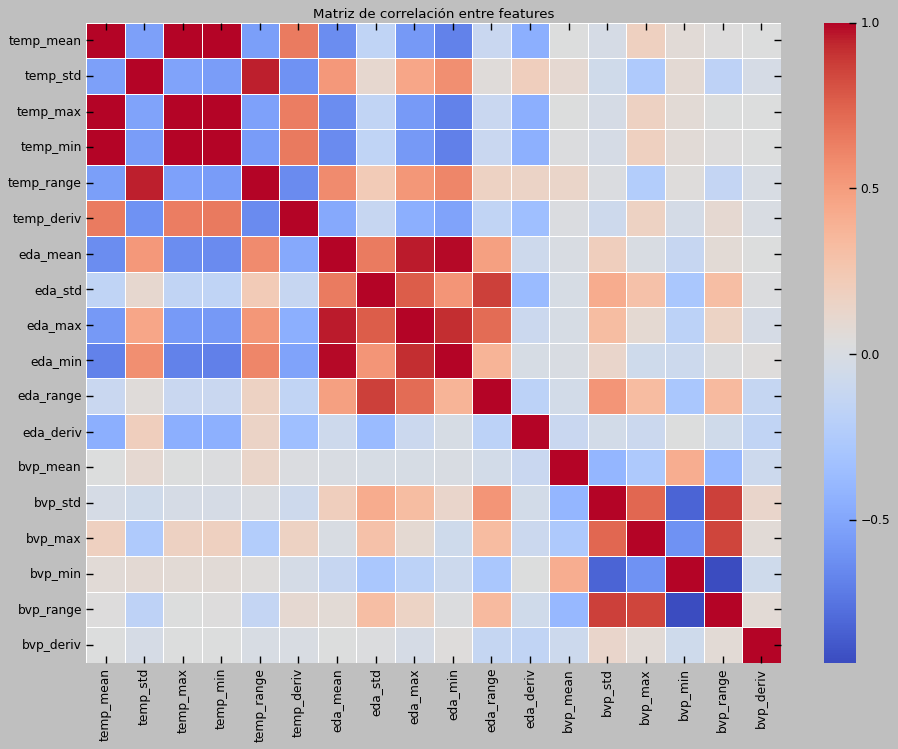

In [3]:
# Paso 6: Visualización exploratoria


# Distribución de clases
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_all, hue='label', palette='Set2', legend=False)
plt.title("Distribución de clases en las ventanas extraídas")
plt.xlabel("Clase")
plt.ylabel("Cantidad de ventanas")
plt.show()


# Pairplot para comparar clases (solo algunas columnas)
sns.pairplot(df_all[["temp_mean", "eda_mean", "bvp_mean", "label"]], hue="label", corner=True, diag_kind="kde")
plt.suptitle("Distribución por clase (media de cada señal)", y=1.02)
plt.show()


# Correlación entre features
plt.figure(figsize=(14,10))
corr = df_all.drop("label", axis=1).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de correlación entre features")
plt.show()

## Entrenamiento y resultados


📊 Classification Report:

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         8
           2     1.0000    1.0000    1.0000         4
           3     1.0000    1.0000    1.0000         3

    accuracy                         1.0000        15
   macro avg     1.0000    1.0000    1.0000        15
weighted avg     1.0000    1.0000    1.0000        15



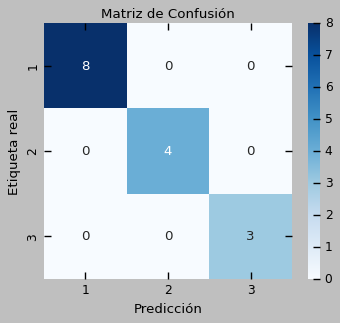

In [4]:
#  Entrenar y evaluar modelo base (Random Forest)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# 1. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 2. Entrenar modelo base
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. Predicciones y evaluación
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 4. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()